# Предсказание рыночной цены на автомобиль

Используем алгоритм K ближайших соседей для предсказания рыночной цены на автомобили.

In [243]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
%matplotlib inline

## Подготовка, очистка данных и нормализация

In [244]:
cars=pd.read_csv("imports-85.data")

In [245]:
cars.head()

,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.60,...,130,mpfi,3.47,2.68,9.00,111,5000,21,27,13495
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


In [246]:
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

In [247]:
cars.columns=cols

In [248]:
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


In [249]:
cars=cars.replace("?",np.NaN)
cars["normalized-losses"]=cars["normalized-losses"].replace("?",np.NaN).astype("float")

In [250]:
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,NaN,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


Исследование пропущенных значений и выбор стратегии замены

In [251]:
cars["normalized-losses"].isnull().sum()/len(cars["normalized-losses"])

0.19607843137254902

Тк пропуски составляют 20% от общего кол-ва строк в датасете лучшая стратегия по замене пропусков - удавление.

In [252]:
len(cars["normalized-losses"])

204

In [253]:
nan=cars.loc[cars["normalized-losses"].isnull()]

nan.iloc[:,[1,11,12,13,18,19,20,21,22,23,24,25]].isnull().sum()

normalized-losses    40
width                 0
height                0
curb-weight           0
bore                  0
stroke                0
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [254]:
cars.dropna(inplace=True)

In [255]:
len(cars)

159

In [256]:
cars.isnull().sum()

symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         0
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [257]:
cars.iloc[:,[1,9,10,11,12,13,18,19,20,21,22,23,24,25]].isnull().sum()
cars=cars.iloc[:,[1,9,10,11,12,13,18,19,20,21,22,23,24,25]]
cars=cars.astype(float)

Нормализуем занчения кроме целевого столбца перед тренировкой модели

In [258]:
def norm (df):
    norm=(df-df.min())/(df.max()-df.min())
    return norm
cars=cars.apply(norm)

In [259]:
cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
2,0.518325,0.455172,0.577236,0.517544,0.471154,0.329325,0.464286,0.633333,0.18750,0.355263,0.551020,0.264706,0.333333,0.295010
3,0.518325,0.441379,0.577236,0.535088,0.471154,0.518231,0.464286,0.633333,0.06250,0.440789,0.551020,0.088235,0.111111,0.411918
5,0.486911,0.662069,0.839024,0.973684,0.605769,0.525989,0.464286,0.633333,0.09375,0.407895,0.551020,0.117647,0.194444,0.420603
7,0.486911,0.662069,0.839024,0.973684,0.625000,0.619860,0.421429,0.633333,0.08125,0.605263,0.551020,0.058824,0.055556,0.626528
9,0.664921,0.503448,0.580488,0.394737,0.471154,0.351823,0.685714,0.347619,0.11250,0.348684,0.673469,0.235294,0.305556,0.377848


## Одномерная модель

Напишу функцию для обучения модели и ее валидации и вычисления средней квадратичной ошибки для к=5

In [261]:
def knn_train_test(df,train_c,target_c):
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    df = df.reindex(shuffled_index)
    train=df[0:int(len(df)/2)]
    test=df[int(len(df)/2):]
    model = KNeighborsRegressor()
    model.fit(df[[train_c]], df[target_c])
    labels = model.predict(test[[train_c]])
    mse=mean_squared_error(test[target_c],labels)
    rmse=mse**0.5
    return rmse

In [262]:
train_c=cars.columns
train_c=train_c.drop("price")


In [264]:

knn_train_test(cars,"city-mpg","price")


0.09160566282688608

In [265]:
result={}
for i in train_c:
    a=knn_train_test(cars,i,"price")
    result[i]=a

In [266]:
rm_result=pd.Series(result)

In [267]:
rm_result.sort_values()

curb-weight          0.060277
wheel-base           0.073329
horsepower           0.075651
width                0.077702
highway-mpg          0.078319
length               0.084624
city-mpg             0.091606
normalized-losses    0.121629
bore                 0.122332
stroke               0.128952
height               0.145687
compression-rate     0.148910
peak-rpm             0.163671
dtype: float64

## Многомерная модель

Изменим функцию для использования k=[1,3,5,7,9]

In [272]:
def knn_train_test_k(df,train_c,target_c):
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    df = df.reindex(shuffled_index)
    train=df[0:int(len(df)/2)]
    test=df[int(len(df)/2):]
    q={}
    k=[1,3,5,7,9]
    for i in k:
        model = KNeighborsRegressor(n_neighbors=i)
        model.fit(df[[train_c]], df[target_c])
        labels = model.predict(test[[train_c]])
        mse=mean_squared_error(test[target_c],labels)
        rmse=mse**0.5
        q[i]=rmse   
    return q
k_rmse_results = {}
for i in train_c:
    a=knn_train_test_k(cars,i,"price")
    k_rmse_results[i]=a

In [273]:
k_rmse_results

{'bore': {1: 0.1463207276871438,
  3: 0.1210739092767343,
  5: 0.12233170840089953,
  7: 0.12486593503676602,
  9: 0.12571948553152937},
 'city-mpg': {1: 0.16333775453581423,
  3: 0.09714061491462248,
  5: 0.09160566282688608,
  7: 0.08953510119623269,
  9: 0.08950476896912854},
 'compression-rate': {1: 0.1754436649893072,
  3: 0.14167935488668432,
  5: 0.14890966909665418,
  7: 0.14627163000543345,
  9: 0.15143780740581028},
 'curb-weight': {1: 0.013222475494870227,
  3: 0.05309986944527839,
  5: 0.060277199287428966,
  7: 0.0649371132083392,
  9: 0.06643930971482344},
 'height': {1: 0.1651710068530323,
  3: 0.1466924208244183,
  5: 0.14568665956217913,
  7: 0.14806184436888528,
  9: 0.14773245550561478},
 'highway-mpg': {1: 0.10262421484158817,
  3: 0.08197261072625463,
  5: 0.07831863284994904,
  7: 0.0819993637427976,
  9: 0.08425037517799348},
 'horsepower': {1: 0.053192980169763,
  3: 0.06214939449790195,
  5: 0.0756506101307259,
  7: 0.08521502599852872,
  9: 0.0846896230948756}

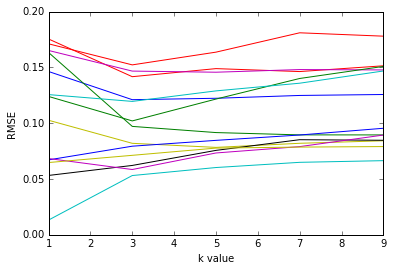

In [274]:
for k,v in sorted(k_rmse_results.items()):
    x = sorted(list(v.keys()))
    y= list(v.values())
    y= [v[i] for i in x]
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

In [276]:
b={}
for k,v in k_rmse_results.items():
    y= np.mean(list(v.values()))
    b[k]=y
b=pd.Series(b).sort_values()
b

curb-weight          0.051595
horsepower           0.072180
wheel-base           0.073711
width                0.074268
length               0.083207
highway-mpg          0.085833
city-mpg             0.106225
normalized-losses    0.127718
bore                 0.128062
stroke               0.131349
height               0.150669
compression-rate     0.152748
peak-rpm             0.169210
dtype: float64

Изменим фукнцию для приема на вход списка имен столбцов для формирования тренировочной выборки вместо использования имени одного столбца

In [278]:
def knn_train_test_k(df,train_c,target_c):
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    df = df.reindex(shuffled_index)
    train=df[0:int(len(df)/2)]
    test=df[int(len(df)/2):]
    q={}
    k=[1,3,5,7,9]
    for i in k:
        model = KNeighborsRegressor(n_neighbors=i)
        model.fit(df[train_c], df[target_c])
        labels = model.predict(test[train_c])
        mse=mean_squared_error(test[target_c],labels)
        rmse=mse**0.5
        q[i]=rmse   
    return q


Использую от 2х до 6ти лучших столбцов из предыдущих тестов

In [240]:
train_c=b.index
train_c=list(train_c[:6])

print(train_c)
k_rmse_results = {}
for i in range(2,6):
    m=train_c[:i-1]
    a=knn_train_test_k(cars,m,"price")
    k_rmse_results[i]=a
print(k_rmse_results)
bb={}
for k,v in k_rmse_results.items():
    y= np.mean(list(v.values()))
    bb[k]=y
bb=pd.Series(bb).sort_values()
bb

['curb-weight', 'horsepower', 'wheel-base', 'width', 'length', 'highway-mpg']
{2: {1: 0.013222475494870227, 3: 0.05309986944527839, 9: 0.06643930971482344, 5: 0.060277199287428966, 7: 0.0649371132083392}, 3: {1: 0.011680663605058796, 3: 0.042690393174186526, 9: 0.06991472915925603, 5: 0.05573228846182606, 7: 0.06281964531916923}, 4: {1: 0.011680663605058796, 3: 0.038916610317879, 9: 0.0650011636910759, 5: 0.04867590241672985, 7: 0.055561415668678456}, 5: {1: 0.011660653873673281, 3: 0.03258196291718005, 9: 0.05939921086480602, 5: 0.04811090748918335, 7: 0.054171470889356706}}


5    0.041185
4    0.043967
3    0.048568
2    0.051595
dtype: float64

['curb-weight', 'horsepower', 'wheel-base', 'width', 'length', 'highway-mpg']
['curb-weight']
['curb-weight', 'horsepower']
['curb-weight', 'horsepower', 'wheel-base']
['curb-weight', 'horsepower', 'wheel-base', 'width']
{2: {1: 0.013222475494870227, 2: 0.05107001100063515, 3: 0.05309986944527839, 4: 0.05732105793782136, 5: 0.060277199287428966, 6: 0.06528764721075624, 7: 0.0649371132083392, 8: 0.06579306078343104, 9: 0.06643930971482344, 10: 0.06902192455470092, 11: 0.07058969456377291, 12: 0.07240250647180207, 13: 0.07363433250435884, 14: 0.07636423384703202, 15: 0.07787362695406264, 16: 0.07884992315174583, 17: 0.08079002165972744, 18: 0.08102542016404073, 19: 0.08146160538161853, 20: 0.0817770365326798, 21: 0.0821924748365548, 22: 0.08210754919007772, 23: 0.08305201010477274, 24: 0.0837283851109784, 25: 0.08421770597485088}, 3: {1: 0.011680663605058796, 2: 0.029486984543239645, 3: 0.042690393174186526, 4: 0.05363079332841598, 5: 0.05573228846182606, 6: 0.05761318722266965, 7: 0.062

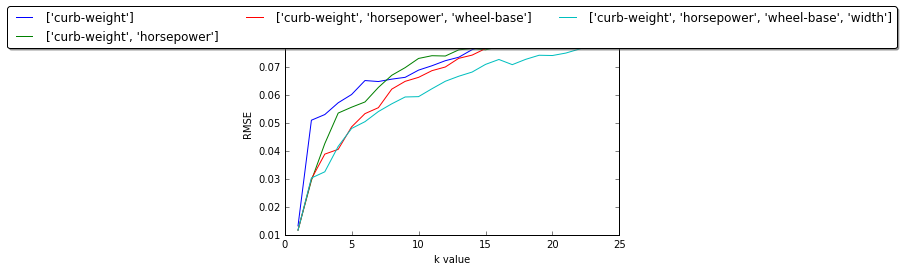

In [241]:
def knn_train_test_k__(df,train_c,target_c):
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    df = df.reindex(shuffled_index)
    train=df[0:int(len(df)/2)]
    test=df[int(len(df)/2):]
    q={}
    k=range(1,26)
    for i in k:
        model = KNeighborsRegressor(n_neighbors=i)
        model.fit(df[train_c], df[target_c])
        labels = model.predict(test[train_c])
        mse=mean_squared_error(test[target_c],labels)
        rmse=mse**0.5
        q[i]=rmse   
    return q
k_rmse_results = {}

train_c=b.index
train_c=list(train_c[:6])

print(train_c)
k_rmse_results = {}
for i in range(2,6):
    m=train_c[:i-1]
    print(m)
    a=knn_train_test_k__(cars,m,"price")
    k_rmse_results[i]=a
print(k_rmse_results)
b={}
for k,v in k_rmse_results.items():
    y= np.mean(list(v.values()))
    b[k]=y
    
for k,v in sorted(k_rmse_results.items()):
    x = sorted(list(v.keys()))
    y= list(v.values())
    y= [v[i] for i in x]
    plt.plot(x,y,label=train_c[:k-1])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
    plt.xlabel('k value')
    plt.ylabel('RMSE')